In [1]:
from __future__ import annotations
"""
TODO(Adriano) after getting some plots for the blobs post-SAE in GPT2, it's important to check whether these
SAEs are actually any good. Unfortunately, I have really bad FVUs, MSEs, etc... It's also unclear if a error
norm of 30 is normal. People seem not to be reporting this very well and it's deeply annoying.

TODO(Adriano) we want to get rid of EOS
"""
import os
from pathlib import Path
import torch
import json
from datasets import load_dataset
import dotenv
from transformers import AutoTokenizer
from transformer_lens.utils import tokenize_and_concatenate
import tqdm
import torch
import matplotlib.pyplot as plt
import shutil
import torch.nn.functional as F

# Load our own imports, etc...
from sans_sae_lib.utils import plot_cosine_kernel, plot_all_nc2_top_pcs, plot_all_nc2_top_pcs_errs
from sans_sae_lib.schemas import ExtractedActivations, FlattenedExtractedActivations
from sans_sae_main import ResidAndLn2Comparer

dotenv.load_dotenv()
assert "CUDA_VISIBLE_DEVICES" in os.environ, "CUDA_VISIBLE_DEVICES is not set"
assert len(os.environ["CUDA_VISIBLE_DEVICES"].strip()) > 0, "CUDA_VISIBLE_DEVICES is empty"

print("="*50 + " [Loading Dataset] " + "="*50) # DEBUG
# dataset = load_dataset("openwebtext", split="train", trust_remote_code=True)
dataset = load_dataset("stas/openwebtext-10k", split="train", trust_remote_code=True) # Smaller version
tokenizer = AutoTokenizer.from_pretrained("gpt2")
token_dataset = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=tokenizer,  # type: ignore
    streaming=True,
    # NOTE: all these have context 128
    max_length=128, #sae.cfg.context_size,
    add_bos_token=True, #sae.cfg.prepend_bos,
)
print("="*50 + " [Loading Model] " + "="*50) # DEBUG
# TODO(Adriano) do this below...
# for d in extractor.cfg_dics:
#     print(d["context_size"]) # NOTE: you should picke the smallest of these...


# Shorten the dataset for testing more quickly
dataset_size = 40 # XXX make this longer please
token_dataset_short = token_dataset[:dataset_size]['tokens']
dataset_length = token_dataset_short.shape[0]
sequence_length = token_dataset_short.shape[1]

/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


================================================== [Loading Dataset] ==================================================
================================================== [Loading Model] ==================================================


In [2]:
print("="*50 + " [Loading Model] " + "="*50) # DEBUG
comparer = ResidAndLn2Comparer()
# print(comparer.model) # DEBUG

================================================== [Loading Model] ==================================================


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model gpt2 into HookedTransformer


/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [3]:
print("="*50 + " [Extracting Activations] " + "="*50) # DEBUG
extracted_activations: ExtractedActivations = comparer.extract_activations(
    token_dataset_short,
    batch_size=40 # Turns out to work on my machine :)
)
print(f"ln2s.shape={extracted_activations.ln2s.shape}")
print(f"sae_outs_per_k.shape={extracted_activations.sae_outs_per_k.shape}")
print(f"sae_ins.shape={extracted_activations.sae_ins.shape}")
print(f"ln2s_saed_per_k.shape={extracted_activations.ln2s_saed_per_k.shape}")

================================================== [Extracting Activations] ==================================================


Batch Size = 40: 100%|██████████| 1/1 [00:05<00:00,  5.28s/it]

ln2s.shape=torch.Size([12, 40, 128, 768])
sae_outs_per_k.shape=torch.Size([9, 12, 40, 128, 768])
sae_ins.shape=torch.Size([12, 40, 128, 768])
ln2s_saed_per_k.shape=torch.Size([9, 12, 40, 128, 768])


In [4]:
"""
DEBUG BLOCK. This block was used to make sure that the top-k forcing is not buggy.
"""
import gc
gc.collect()
torch.cuda.empty_cache()
with torch.no_grad():
    print("="*50 + " [Tesing that encoding and then decoding = just forwards] " + "="*50) # DEBUG
    def test_encode_decode_consistency():
        # Test that encoding and decoding are consistent
        # Create a random tensor of shape (batch, seq, d_model)
        n_layers = 12
        batch_size = 10
        seq_length = 128
        d_model = 768
        test_tensor = torch.randn(n_layers, batch_size, seq_length, d_model).to(comparer.device) * 20
        encoded = torch.stack([sae.encode(test_tensor) for sae in comparer.saes])
        decoded = torch.stack([sae.decode(encoded[i]) for i, sae in enumerate(comparer.saes)])
        passed_forwards = torch.stack([sae(test_tensor) for sae in comparer.saes])
        mae = (passed_forwards - decoded).abs().mean()
        assert torch.allclose(passed_forwards, decoded), f"MAE: {mae}"
    test_encode_decode_consistency()
    print("="*50 + " [OK... enough?] " + "="*50) # DEBUG

    print("="*50 + " [Tesing that apply sae equally good to forward] " + "="*50) # DEBUG
    def test_apply_sae_equally_good_to_forward():
        # Test that encoding and decoding are consistent
        # Create a random tensor of shape (batch, seq, d_model)
        n_layers = 12
        batch_size = 10
        seq_length = 128
        d_model = 768
        test_tensor = torch.randn(n_layers, batch_size, seq_length, d_model).to(comparer.device) * 20
        passed_apply = comparer.apply_sae(test_tensor)
        passed_forwards = torch.stack([sae(test_tensor[i]) for i, sae in enumerate(comparer.saes)])
        mae = (passed_apply - passed_forwards).abs().mean()
        assert torch.allclose(passed_apply, passed_forwards), f"MAE: {mae}"
    test_apply_sae_equally_good_to_forward()
    print("="*50 + " [OK... enough?] " + "="*50) # DEBUG

    print("="*50 + " [Tesing that TopK works as intended] " + "="*50) # DEBUG
    def test_topk_works_as_intended():
        # Test that TopK works as intended
        # Create a random tensor of shape (batch, seq, d_model)
        n_layers = 12
        batch_size = 10
        seq_length = 128
        d_model = 768
        test_tensor = torch.randn(n_layers, batch_size, seq_length, d_model).to(comparer.device) * 20
        test_tensor = F.relu(test_tensor)
        assert test_tensor.min().item() >= 0, f"test_tensor.min()={test_tensor.min().item()}"
        k = d_model
        topk_values, topk_indices = torch.topk(test_tensor, k=k, dim=-1)
        mask = torch.zeros_like(test_tensor)
        mask.scatter_(-1, topk_indices, topk_values)
        assert torch.allclose(test_tensor, mask), f"test_tensor.min()={test_tensor.min().item()}"
    test_topk_works_as_intended()
    print("="*50 + " [OK... enough?] " + "="*50) # DEBUG

    print("="*50 + " [Tesing that TopK forcing is not clearly wrong] " + "="*50) # DEBUG
    def test_forcing_ok():
        # Test that forcing topk is not clearly wrong by making sure that
        # if k >= 768 you get the same result as just applying the SAE normally
        # Create a random tensor of shape (batch, seq, d_model)
        n_layers = 12
        batch_size = 10
        seq_length = 128
        d_model = 768
        test_tensor = torch.randn(n_layers, batch_size, seq_length, d_model).to(comparer.device) * 20
        d_sae = comparer.saes[0].encode(test_tensor[0]).shape[-1]
        unforced = comparer.apply_sae(test_tensor)
        forced_similar = comparer.apply_sae(test_tensor, force_topk=d_sae)
        forced_dissimilar = comparer.apply_sae(test_tensor, force_topk=1)
        mae_similar = (unforced - forced_similar).abs().mean()
        mae_dissimilar = (unforced - forced_dissimilar).abs().mean()
        assert not torch.allclose(unforced, forced_dissimilar), f"MAE: {mae_dissimilar}" # run this first since usually passes
        assert torch.allclose(unforced, forced_similar), f"MAE: {mae_similar} (dissimilar: {mae_dissimilar})"
        
    test_forcing_ok()
    print("="*50 + " [OK (enough??)] " + "="*50) # DEBUG

================================================== [Tesing that encoding and then decoding = just forwards] ==================================================
================================================== [OK... enough?] ==================================================
================================================== [Tesing that apply sae equally good to forward] ==================================================
================================================== [OK... enough?] ==================================================
================================================== [Tesing that TopK works as intended] ==================================================
================================================== [OK... enough?] ==================================================
================================================== [Tesing that TopK forcing is not clearly wrong] ==================================================
================================================

In [5]:
print("="*50 + " [Flattening + Calculating PCA & Errors] " + "="*50) # DEBUG
extracted_activations_flattened: FlattenedExtractedActivations = extracted_activations.flatten()
print("="*50 + " [Done, now ready to plot (next cell)] " + "="*50) # DEBUG

================================================== [Flattening + Calculating PCA & Errors] ==================================================
================================================== [Done, now ready to plot (next cell)] ==================================================


In [6]:
"""Create the global plots folder for us to be able to plot everything"""
global_plot_folder_path = Path("sae_sans_plots")
if global_plot_folder_path.exists() and len(list(global_plot_folder_path.glob("*"))) == 0:
    shutil.rmtree(global_plot_folder_path)
global_plot_folder_path.mkdir(parents=True, exist_ok=False)

In [7]:
"""
Plot the errors from the SAEs, etc...
"""
# res folders
res_sae_err_norms_output_folder = global_plot_folder_path / "res_sae_err_norms" # fmt: skip
res_sae_variance_explained_output_folder = global_plot_folder_path / "res_sae_variance_explained" # fmt: skip
res_sae_mse_output_folder = global_plot_folder_path / "res_sae_mse" # fmt: skip

# ln2 folders
ln2_sae_err_norms_output_folder = global_plot_folder_path / "ln2_sae_err_norms" # fmt: skip
ln2_sae_variance_explained_output_folder = global_plot_folder_path / "ln2_sae_variance_explained" # fmt: skip
ln2_sae_mse_output_folder = global_plot_folder_path / "ln2_sae_mse" # fmt: skip

for (name, folder, arr_per_k) in tqdm.tqdm([
    # res
    ("res_sae_err_norms", res_sae_err_norms_output_folder, extracted_activations_flattened.res_sae_error_norms), # fmt: skip
    ("res_sae_variance_explained", res_sae_variance_explained_output_folder, extracted_activations_flattened.res_sae_var_explained), # fmt: skip
    ("res_sae_mse", res_sae_mse_output_folder, extracted_activations_flattened.res_sae_mse), # fmt: skip
    # ln2
    ("ln2_sae_err_norms", ln2_sae_err_norms_output_folder, extracted_activations_flattened.ln2_sae_error_norms), # fmt: skip
    ("ln2_sae_variance_explained", ln2_sae_variance_explained_output_folder, extracted_activations_flattened.ln2_sae_var_explained), # fmt: skip
    ("ln2_sae_mse", ln2_sae_mse_output_folder, extracted_activations_flattened.ln2_sae_mse), # fmt: skip
    
]):
    if folder.exists() and len(list(folder.glob("*"))) == 0:
        shutil.rmtree(folder)
    folder.mkdir(parents=True, exist_ok=False)
    # Check that the first two dimensions are k and layer
    assert arr_per_k.shape[0] == len(comparer.forced_ks), f"arr_per_k.shape[0]={arr_per_k.shape[0]}, need {len(comparer.forced_ks)}" # fmt: skip
    assert arr_per_k.shape[1] == len(comparer.saes), f"arr_per_k.shape[1]={arr_per_k.shape[1]}, need {len(comparer.saes)}" # fmt: skip
    for layer in tqdm.trange(len(comparer.saes)):
        for kidx, k in tqdm.tqdm(enumerate(comparer.forced_ks), total=len(comparer.forced_ks), desc=f"layer {layer} x ks"):
            arr = arr_per_k[kidx, layer]
            assert arr.ndim == 1 # just a bunch of errors, etc...
            filepath = folder / f"layer_{layer}_k_{k}.png"
            # TODO(Adriano) its not clear if this here is going to be desceptive or not
            # since variance explained could be... negative!
            plt.hist(arr.cpu().log10().numpy(), bins=100)
            plt.title(f"log10({name}) (layer {layer}) @ top=k {k}")
            plt.savefig(filepath)
            plt.close()
            filepath_meta = folder / f"layer_{layer}_k_{k}.json"
            with open(filepath_meta, "w") as f:
                json.dump({
                    "layer": layer,
                    "name": name,
                    "shape": str(arr.shape),
                    "min": arr.min().item(),
                    "max": arr.max().item(),
                    "mean": arr.mean().item(),
                    "std": arr.std().item(),
                    "median": arr.median().item(),
                    "q1": arr.quantile(0.25).item(),
                    "q3": arr.quantile(0.75).item(),
                    "k": k
                }, f, indent=4)
            


  0%|          | 0/6 [00:00<?, ?it/s]









layer 0 x ks: 100%|██████████| 9/9 [00:01<00:00,  5.93it/s]










layer 1 x ks: 100%|██████████| 9/9 [00:01<00:00,  5.24it/s]










layer 2 x ks: 100%|██████████| 9/9 [00:01<00:00,  6.56it/s]










layer 3 x ks: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]










layer 4 x ks: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s]










layer 5 x ks: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s]










layer 6 x ks: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s]










layer 7 x ks: 100%|██████████| 9/9 [00:01<00:00,  8.44it/s]










layer 8 x ks: 100%|██████████| 9/9 [00:01<00:00,  8.16it/s]










layer 9 x ks: 100%|██████████| 9/9 [00:01<00:00,  8.18it/s]










layer 10 x ks: 100%|██████████| 9/9 [00:01<00:00,  5.60it/s]










 17%|█▋        | 1/6 [00:16<01:20, 16.06s/it]









layer 0 x ks: 100%|██████████| 9/9 [00:01<00:00,  8.10it/s]










layer 1 x ks: 100%|██████████| 9/9 [00:01<00:00,  7.93it/

In [8]:
"""
Calculate the similarity via cosine between each pair of input and output PCs (after
applying an SAE). If the SAE is good, we should expect an exact match (i.e. a diagonal-
like stripe).
"""
plots_output_folder = global_plot_folder_path / "plots_cosine_sim_pca_post_sae"
if plots_output_folder.exists() and len(list(plots_output_folder.glob("*"))) == 0:
    shutil.rmtree(plots_output_folder)
plots_output_folder.mkdir(parents=True, exist_ok=False)

# You can also analyze multiple layers
print("\nAnalyzing multiple layers...")
for layer in tqdm.trange(len(comparer.saes)):
    # Acquire all the principle components we want to compare
    eigenvectors_sae_ins = extracted_activations_flattened.sae_ins_pca_eigenvectors[layer] # fmt: skip
    eigenvectors_ln2s = extracted_activations_flattened.ln2s_pca_eigenvectors[layer] # fmt: skip
    for kidx, k in tqdm.tqdm(enumerate(comparer.forced_ks), total=len(comparer.forced_ks), desc=f"layer {layer} x ks"): # fmt: skip
        eigenvectors_sae_outs = extracted_activations_flattened.sae_outs_per_k_pca_eigenvectors[kidx, layer] # fmt: skip
        eigenvectors_ln2s_saed = extracted_activations_flattened.ln2s_saed_per_k_pca_eigenvectors[kidx, layer] # fmt: skip
        assert eigenvectors_sae_outs.shape == eigenvectors_sae_ins.shape, f"eigenvectors_sae_outs.shape={eigenvectors_sae_outs.shape}, eigenvectors_sae_ins.shape={eigenvectors_sae_ins.shape}" # fmt: skip
        assert eigenvectors_ln2s_saed.shape == eigenvectors_ln2s.shape, f"eigenvectors_ln2s_saed.shape={eigenvectors_ln2s_saed.shape}, eigenvectors_ln2s.shape={eigenvectors_ln2s.shape}" # fmt: skip
        # Save them to the plot folder
        cosine_sim = plot_cosine_kernel(eigenvectors_sae_ins, eigenvectors_sae_outs, force_positive=True, save_to_file=plots_output_folder / f"layer_{layer}_k_{k}_res.png") # fmt: skip
        cosine_sim = plot_cosine_kernel(eigenvectors_ln2s, eigenvectors_ln2s, force_positive=True, save_to_file=plots_output_folder / f"layer_{layer}_k_{k}_ln2.png") # fmt: skip
    
    # TODO(Adriano) this is some tidbit code written by Claude, not sure if I honestly want it :P
    # Find the top aligned eigenvectors
    # max_values, max_indices = torch.max(cosine_sim.abs(), dim=1)
    # top_k = 5
    # top_indices = torch.argsort(max_values, descending=True)[:top_k]
    
    # print(f"Top {top_k} aligned eigenvector pairs (SAE in → SAE out):")
    # for i, idx in enumerate(top_indices):
    #     out_idx = max_indices[idx]
    #     sim_value = cosine_sim[idx, out_idx].item()
    #     print(f"  {i+1}. In eigenvector {idx} aligns with out eigenvector {out_idx} (sim={sim_value:.4f})")
    pass




Analyzing multiple layers...


100%|██████████| 12/12 [02:36<00:00, 13.03s/it]


In [9]:
"""
Plot for each pair of PCs the histogram of their values on that projection.
"""
res_sae_in_pca_histograms_folder = global_plot_folder_path / "res_sae_in_pca_histograms"
res_sae_out_pca_histograms_folder = global_plot_folder_path / "res_sae_out_pca_histograms"
ln2_pca_histograms_folder = global_plot_folder_path / "ln2_pca_histograms"
ln2_sae_effect_pca_histograms_folder = global_plot_folder_path / "ln2_sae_effect_pca_histograms"
n_pcs = 2 # ehh

for output_folder, (activations, mean, eigenvectors), per_k in tqdm.tqdm([
    (
        res_sae_in_pca_histograms_folder,
        (
            extracted_activations_flattened.sae_ins,
            extracted_activations_flattened.sae_ins_means,
            extracted_activations_flattened.sae_ins_pca_eigenvectors
        ),
        False
    ),
    (
        res_sae_out_pca_histograms_folder, 
        (
            extracted_activations_flattened.sae_outs_per_k,
            extracted_activations_flattened.sae_outs_per_k_means,
            extracted_activations_flattened.sae_outs_per_k_pca_eigenvectors
        ),
        True
    ),
    (
        ln2_pca_histograms_folder,
        (
            extracted_activations_flattened.ln2s,
            extracted_activations_flattened.ln2s_means,
            extracted_activations_flattened.ln2s_pca_eigenvectors
        ),
        False
    ),
    (
        ln2_sae_effect_pca_histograms_folder,
        (
            extracted_activations_flattened.ln2s_saed_per_k,
            extracted_activations_flattened.ln2s_saed_per_k_means,
            extracted_activations_flattened.ln2s_saed_per_k_pca_eigenvectors
        ),
        True
    )
]):
    for layer in tqdm.trange(len(comparer.saes)):
        if per_k:
            for kidx, k in tqdm.tqdm(enumerate(comparer.forced_ks), total=len(comparer.forced_ks), desc=f"layer {layer} x ks"): # fmt: skip
                output_folder_layer = output_folder / f"layer_{layer}_k_{k}"
                output_folder_layer.mkdir(parents=True, exist_ok=False)
                plot_all_nc2_top_pcs(n_pcs, activations[kidx, layer], mean[kidx, layer], eigenvectors[kidx, layer], output_folder_layer)
        else:
            output_folder_layer = output_folder / f"layer_{layer}"
            output_folder_layer.mkdir(parents=True, exist_ok=False)
            plot_all_nc2_top_pcs(n_pcs, activations[layer], mean[layer], eigenvectors[layer], output_folder_layer)

  0%|          | 0/4 [00:00<?, ?it/s]

Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 25%|██▌       | 1/4 [00:07<00:23,  7.89s/it]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]





Plotting PCA histograms: 100%|██

  0%|          | 0/4 [00:00<?, ?it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]





Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]




Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]





Plotting PCA histograms: 100%|██████████| 1/1 [00:00<00:

KeyboardInterrupt: 

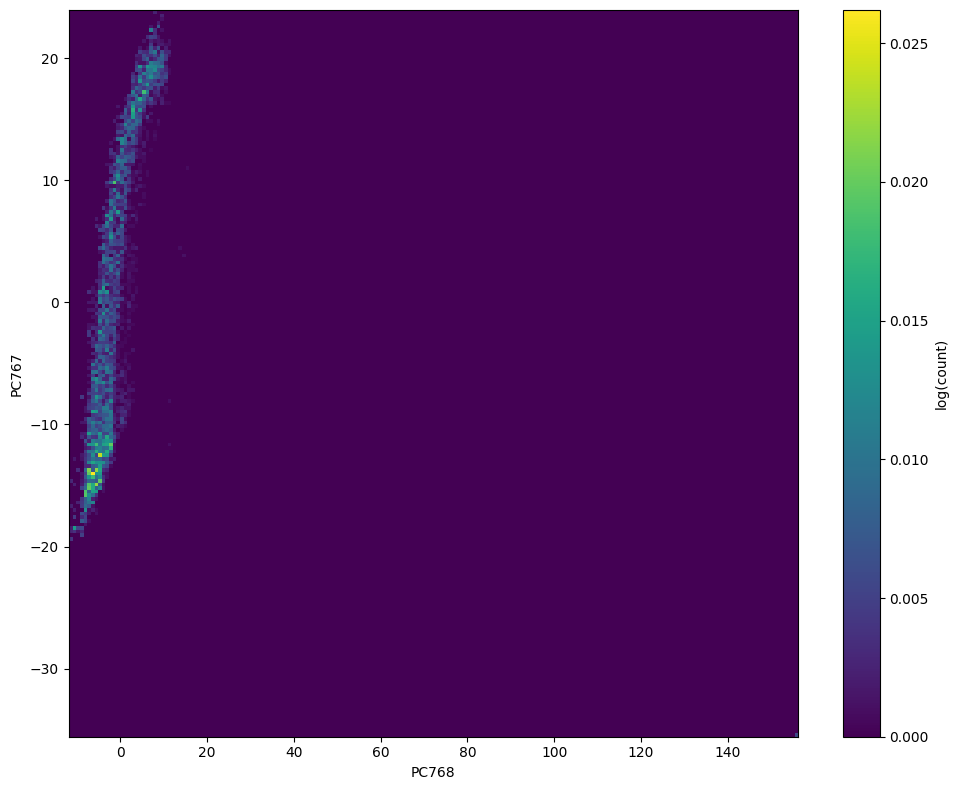

In [10]:
# DEBUG
# import importlib
# import sans_sae_lib.utils
# importlib.reload(sans_sae_lib.utils)
# plot_all_nc2_top_pcs_errs = sans_sae_lib.utils.plot_all_nc2_top_pcs_errs
"""
Plot the error projected onto each pair of PCs as above. Specifically,
we accumulate in each bin (same bins as above) the error in the SAE-modified
representation in that bin. Then we store 2 versions:
1. Divide by the total number of samples (so basically this is proportional to
    expected error)
2. Divide by the number of samples in that bin (so basically here we are looking to
    see if there is an additional contribution of the SAE to that bin above just
    "there were more samples here")

And for each of these two we do it for each of:
1. Error norm (on that datapoint)
2. Variance explained (on that datapoint)
3. MSE (on that datapoint)
"""
res_sae_in_pca_histograms_folder = global_plot_folder_path / "res_sae_in_err_pca_histograms"
res_sae_out_pca_histograms_folder = global_plot_folder_path / "res_sae_out_err_pca_histograms"
ln2_pca_histograms_folder = global_plot_folder_path / "ln2_err_pca_histograms"
ln2_sae_effect_pca_histograms_folder = global_plot_folder_path / "ln2_sae_effect_err_pca_histograms"
n_pcs = 2 # ehh, copy from above lmao
for output_folder, per_k, (activations, mean, eigenvectors, err_norm, err_var_explained, err_mse) in tqdm.tqdm([
    (
        res_sae_in_pca_histograms_folder,
        # NOTE: per_k refers to whether or not the activations, mean, etc... are per-k; if they are not
        # then they need to be repeated for the zip to work fine (look below)
        False,
        (
            # Projection (binning) data
            extracted_activations_flattened.sae_ins,
            extracted_activations_flattened.sae_ins_means,
            extracted_activations_flattened.sae_ins_pca_eigenvectors,
            # Errors (coloring data)
            extracted_activations_flattened.res_sae_error_norms, # NOTE: this is also per k
            extracted_activations_flattened.res_sae_var_explained, # NOTE: this is also per k
            extracted_activations_flattened.res_sae_mse # NOTE: this is also per k
        )
    ),
    (
        res_sae_out_pca_histograms_folder, 
        True,
        (
            # Projection (binning) data
            extracted_activations_flattened.sae_outs_per_k,
            extracted_activations_flattened.sae_outs_per_k_means,
            extracted_activations_flattened.sae_outs_per_k_pca_eigenvectors,
            # Errors (coloring data)
            extracted_activations_flattened.res_sae_error_norms, # NOTE: this is also per k
            extracted_activations_flattened.res_sae_var_explained, # NOTE: this is also per k
            extracted_activations_flattened.res_sae_mse # NOTE: this is also per k
        )
    ),
    (
        ln2_pca_histograms_folder,
        False,
        (
            # Projection (binning) data
            extracted_activations_flattened.ln2s,
            extracted_activations_flattened.ln2s_means,
            extracted_activations_flattened.ln2s_pca_eigenvectors,
            # Errors (coloring data)
            extracted_activations_flattened.ln2_sae_error_norms, # NOTE: this is also per k
            extracted_activations_flattened.ln2_sae_var_explained, # NOTE: this is also per k
            extracted_activations_flattened.ln2_sae_mse # NOTE: this is also per k
        )
    ),
    (
        ln2_sae_effect_pca_histograms_folder,
        True,
        (
            # Projection (binning) data
            extracted_activations_flattened.ln2s_saed_per_k,
            extracted_activations_flattened.ln2s_saed_per_k_means,
            extracted_activations_flattened.ln2s_saed_per_k_pca_eigenvectors,
            # Errors (coloring data)
            extracted_activations_flattened.ln2_sae_error_norms, # NOTE: this is also per k
            extracted_activations_flattened.ln2_sae_var_explained, # NOTE: this is also per k
            extracted_activations_flattened.ln2_sae_mse # NOTE: this is also per k
        )
    )
]):
    for layer in tqdm.trange(len(comparer.saes)):
        for kidx, k in tqdm.tqdm(enumerate(comparer.forced_ks), total=len(comparer.forced_ks), desc=f"layer {layer} x ks"): # fmt: skip
            output_folder_layer = output_folder / f"layer_{layer}_{k}"
            output_folder_layer.mkdir(parents=True, exist_ok=False)
            err_type_names = ["error_norm", "variance_explained", "mse"] # fmt: skip
            # NOTE: errors are ALWAYS per k
            err_arrays = [err_norm[kidx, layer], err_var_explained[kidx, layer], err_mse[kidx, layer]] # fmt: skip
            for err_type_name, err_array in zip(err_type_names, err_arrays):
                for normalize_by_n_in_bin, normalize_by_n_in_bin_name in zip([False, True], ["unnormalized", "normalized"]):
                    sub_output_folder = output_folder_layer / f"{normalize_by_n_in_bin_name}_{err_type_name}_k_{k}"
                    plot_all_nc2_top_pcs_errs(
                        n_pcs,
                        # Projection parameters
                        # NOTE: this is where the "zip" comes into play
                        activations[kidx, layer] if per_k else activations[layer],
                        mean[kidx, layer] if per_k else mean[layer],
                        eigenvectors[kidx, layer] if per_k else eigenvectors[layer],
                        # Error parameters + Plotting n stuff
                        err_array, # NOTE: already layered
                        normalize_by_n_in_bin, # normalize by in bin but not total
                        not normalize_by_n_in_bin, # normalize by total not in bin
                        # Storage parameters
                        sub_output_folder,
                    )

In [20]:
"""
Generally the output will look like this:

sae_sans_plots
├── ln2_err_pca_histograms
│   ├── layer_0
│   │   ├── normalized_error_norm
│   │   │   └── pc1_pc2.png
│   │   ├── normalized_mse
│   │   │   └── pc1_pc2.png
│   │   ├── normalized_variance_explained
│   │   │   └── pc1_pc2.png
│   │   ├── unnormalized_error_norm
│   │   │   └── pc1_pc2.png
│   │   ├── unnormalized_mse
│   │   │   └── pc1_pc2.png
│   │   └── unnormalized_variance_explained
│   │       └── pc1_pc2.png
│   ...
├── ln2_pca_histograms
│   ├── layer_0
│   │   └── pc1_pc2.png
│   ...
├── ln2_sae_effect_err_pca_histograms
│   ├── layer_0
│   │   ├── normalized_error_norm
│   │   │   └── pc1_pc2.png
│   │   ├── normalized_mse
│   │   │   └── pc1_pc2.png
│   │   ├── normalized_variance_explained
│   │   │   └── pc1_pc2.png
│   │   ├── unnormalized_error_norm
│   │   │   └── pc1_pc2.png
│   │   ├── unnormalized_mse
│   │   │   └── pc1_pc2.png
│   │   └── unnormalized_variance_explained
│   │       └── pc1_pc2.png
│   ...
├── ln2_sae_effect_pca_histograms
│   ├── layer_0
│   │   └── pc1_pc2.png
│   ├── layer_1
│   │   └── pc1_pc2.png
│   ...
├── ln2_sae_err_norms
│   ├── layer_0.json
│   ├── layer_0.png
│   ...
├── ln2_sae_mse
│   ├── layer_0.json
│   ├── layer_0.png
│   ...
├── ln2_sae_variance_explained
│   ├── layer_0.json
│   ├── layer_0.png
│   ...
├── plots_cosine_sim_pca_post_sae
│   ├── layer_0.png
│   ├── layer_0_sae_ins_ln2.png
│   ...
├── res_sae_err_norms
│   ├── layer_0.json
│   ├── layer_0.png
│   ...
├── res_sae_in_err_pca_histograms
│   ├── layer_0
│   │   ├── normalized_error_norm
│   │   │   └── pc1_pc2.png
|   |   |   ... (there might be more pairs of PCs)
│   │   ├── normalized_mse
│   │   │   └── pc1_pc2.png
│   │   ├── normalized_variance_explained
│   │   │   └── pc1_pc2.png
│   │   ├── unnormalized_error_norm
│   │   │   └── pc1_pc2.png
│   │   ├── unnormalized_mse
│   │   │   └── pc1_pc2.png
│   │   └── unnormalized_variance_explained
│   │       └── pc1_pc2.png
│   ...
├── res_sae_in_pca_histograms
│   ├── layer_0
│   │   └── pc1_pc2.png
│   ├── layer_1
│   │   └── pc1_pc2.png
│   ...
├── res_sae_mse
│   ├── layer_0.json
│   ├── layer_0.png
│   ├── ...
|   ...
├── res_sae_out_err_pca_histograms
│   ├── layer_0
│   │   ├── normalized_error_norm
│   │   │   └── pc1_pc2.png
│   │   ├── normalized_mse
│   │   │   └── pc1_pc2.png
│   │   ├── normalized_variance_explained
│   │   │   └── pc1_pc2.png
│   │   ├── unnormalized_error_norm
│   │   │   └── pc1_pc2.png
|   |   |   ... (there might be more pairs of PCs)
│   │   ├── unnormalized_mse
│   │   │   └── pc1_pc2.png
│   │   └── unnormalized_variance_explained
│   │       └── pc1_pc2.png
│   ├── layer_1
│   │   ├── normalized_error_norm
│   │   ...
|   ...
├── res_sae_out_pca_histograms
│   ├── layer_0
│   │   └── pc1_pc2.png
│   ├── layer_1
│   │   └── pc1_pc2.png
│   ...
└── res_sae_variance_explained
    ├── layer_0.json
    ├── layer_0.png
    ├── ...
    ...
"""

'\nGenerally the output will look like this:\n\nsae_sans_plots\n├── ln2_err_pca_histograms\n│   ├── layer_0\n│   │   ├── normalized_error_norm\n│   │   │   └── pc1_pc2.png\n│   │   ├── normalized_mse\n│   │   │   └── pc1_pc2.png\n│   │   ├── normalized_variance_explained\n│   │   │   └── pc1_pc2.png\n│   │   ├── unnormalized_error_norm\n│   │   │   └── pc1_pc2.png\n│   │   ├── unnormalized_mse\n│   │   │   └── pc1_pc2.png\n│   │   └── unnormalized_variance_explained\n│   │       └── pc1_pc2.png\n│   ...\n├── ln2_pca_histograms\n│   ├── layer_0\n│   │   └── pc1_pc2.png\n│   ...\n├── ln2_sae_effect_err_pca_histograms\n│   ├── layer_0\n│   │   ├── normalized_error_norm\n│   │   │   └── pc1_pc2.png\n│   │   ├── normalized_mse\n│   │   │   └── pc1_pc2.png\n│   │   ├── normalized_variance_explained\n│   │   │   └── pc1_pc2.png\n│   │   ├── unnormalized_error_norm\n│   │   │   └── pc1_pc2.png\n│   │   ├── unnormalized_mse\n│   │   │   └── pc1_pc2.png\n│   │   └── unnormalized_variance_explain